In [1]:
%load_ext autoreload
%autoreload 2
from copy import deepcopy
import os
os.chdir("/home/jakob/doktor/projects/EnsembleUncertainty/code")
"""Learing "logit" distribution in regression example"""
from pathlib import Path
from datetime import datetime
import logging
import numpy as np
import matplotlib.pyplot as plt
import torch

from src.dataloaders import gaussian_sinus, one_dim_regression
import src.utils as utils
from src.distilled import gauss_logits, gauss_mix, norm_inv_wish
from src.ensemble import simple_regressor, ensemble

import src.metrics as metrics
import src.loss as custom_loss
from src import utils
from src.utils_dir import tikz as tikz_utils
from src.utils_dir import experiments as experiment_utils
from src.utils_dir import pytorch as torch_utils
from src.utils_dir import plot as plot_utils

LOGGER = logging.getLogger(__name__)
EXPERIMENT_NAME = "niw_distillation"

# Settings
class Args():
    pass
args = Args()
args.seed = 1
args.gpu = True
args.log_dir = Path("./logs")

args.log_level = logging.INFO
args.retrain = True

args.num_ensemble_members=50
args.num_epochs=100
args.lr = 0.01

log_file = Path("{}_{}.log".format(
    EXPERIMENT_NAME,
    datetime.now().strftime("%Y%m%d_%H%M%S")))
utils.setup_logger(log_path=Path.cwd() / args.log_dir / log_file,
                   log_level=args.log_level)

plt.rcParams['figure.figsize'] = [30, 15]

tex_dir = Path("/home/jakob/doktor/projects/EnsembleUncertainty/paper/Paper")

2020-04-06 12:55:11,643 INFO  root            - Log at /home/jakob/doktor/projects/EnsembleUncertainty/code/logs/niw_distillation_20200406_125511.log


In [2]:
def make_plots(distilled_model, data):
    test_loader = torch.utils.data.DataLoader(data,
                                              batch_size=16,
                                              shuffle=True,
                                              num_workers=0)

    predictions = np.zeros((data.n_samples, distilled_model.output_size))
    all_x = np.zeros((data.n_samples, 1))
    all_y = np.zeros((data.n_samples, 1))

    idx = 0
    for batch in test_loader:
        inputs, targets = batch

        predictions[idx * test_loader.batch_size:(idx + 1) * test_loader.batch_size, :, :] = \
            distilled_model.predict(inputs, t=None).data.numpy()

        all_x[idx * test_loader.batch_size:(idx + 1) *
              test_loader.batch_size, :] = inputs
        all_y[idx * test_loader.batch_size:(idx + 1) *
              test_loader.batch_size, :] = targets

        idx += 1

    plt.scatter(np.squeeze(all_x), np.squeeze(all_y), label="Data", marker=".")

    plt.errorbar(np.squeeze(all_x),
                 predictions[:, 0],
                 np.sqrt(predictions[:, 1]),
                 label="Distilled model predictions",
                 marker=".",
                 ls="none")

    plt.legend()
    plt.show()


In [3]:
LOGGER.info("Args: {}".format(args))
device = utils.torch_settings(args.seed, args.gpu)
LOGGER.info("Creating dataloader")
data = gaussian_sinus.GaussianSinus(range_=(-3, 3), store_file=Path("data/tmp_data"))

input_size = 1
ensemble_output_size = 2
layer_sizes = [1, 10, 10, ensemble_output_size] # Mean and variance
args.num_ensemble_members = 2
args.num_epochs=25
args.lr = 0.001
args.log_level = logging.INFO
train_loader = torch.utils.data.DataLoader(data,
                                           batch_size=32,
                                           shuffle=True)

prob_ensemble = ensemble.Ensemble(ensemble_output_size)
for _ in range(args.num_ensemble_members):

    model = simple_regressor.Model(layer_sizes=layer_sizes,
                                 device=device,
                                 variance_transform=utils.positive_linear_asymptote(),
                                 loss_function=custom_loss.gaussian_nll_1d)
    model.optimizer = torch.optim.Adam(model.parameters(),
                                         lr=args.lr)
    #model.switch_active_network("mu")
    prob_ensemble.add_member(model)
squared_error_metric = metrics.Metric(name="MSE",
                                      function=metrics.mean_squared_error)
prob_ensemble.add_metrics([squared_error_metric])
prob_ensemble.train(train_loader, args.num_epochs)

ensemble_experiment = experiment_utils.experiment_info(model, args)

2020-04-06 12:55:16,050 INFO  __main__        - Args: <__main__.Args object at 0x7f9f706321d0>
2020-04-06 12:55:16,104 INFO  __main__        - Creating dataloader
2020-04-06 12:55:16,105 INFO  GaussianSinus   - Sampling new data
2020-04-06 12:55:16,341 INFO  Model           - Moving model to device: cuda
2020-04-06 12:55:16,341 INFO  Model           - Using variance transform: <lambda>
2020-04-06 12:55:18,114 WARNING Ensemble        - Is subclass check disabled
2020-04-06 12:55:18,114 INFO  Ensemble        - Adding <class 'src.ensemble.simple_regressor.Model'> to ensemble
2020-04-06 12:55:18,115 INFO  Model           - Moving model to device: cuda
2020-04-06 12:55:18,115 INFO  Model           - Using variance transform: <lambda>
2020-04-06 12:55:18,117 WARNING Ensemble        - Is subclass check disabled
2020-04-06 12:55:18,117 INFO  Ensemble        - Adding <class 'src.ensemble.simple_regressor.Model'> to ensemble
2020-04-06 12:55:18,118 INFO  Ensemble        - Adding metric: MSE
2020

2020-04-06 12:57:35,052 INFO  GaussianSinus   - Sampling new data


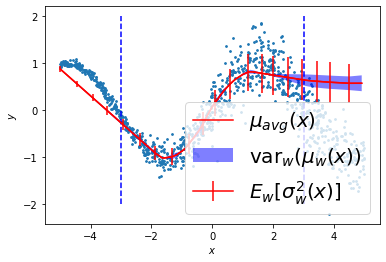

In [4]:
test_data_set = gaussian_sinus.GaussianSinus(range_=(-5, 5),
                                             store_file=Path("tmp_data"))
test_data = test_data_set.get_full_data(sorted_=True)

with torch.no_grad():
    N = len(test_data)
    x = torch.tensor(test_data[:, 0]).float()
    y = torch.tensor(test_data[:, 1]).float()
    x = x.reshape((N, 1))
    ens_output = prob_ensemble.predict(x).cpu()
    x = x.reshape(y.size())
    mu_ens, sigma_sq_ens = ens_output[:, :, 0],  ens_output[:, :, 1]
    mean_mu_ens, sigma_sq = torch_utils.gaussian_mixture_moments(mu_ens, sigma_sq_ens)
    ale_ens, epi_ens = metrics.uncertainty_separation_parametric(mu_ens, sigma_sq_ens)

_, ax = plt.subplots()
plot_utils.plot_uncert(ax, x, y, mean_mu=mean_mu_ens,every_nth=10, ale=ale_ens, epi=epi_ens)

In [5]:
#Create distilled!
hidden_size = 20
distilled_output_size = ensemble_output_size * 2 + 2
layer_sizes = [input_size, hidden_size, hidden_size, distilled_output_size]
#distilled_model = gauss_logits.Model(
#    layer_sizes=layer_sizes,
#    variance_transform=utils.positive_linear_asymptote(),
#    teacher=prob_ensemble,
#    device=device,
#    learning_rate=args.lr)
args.lr = 0.0001
distilled_model = norm_inv_wish.Model(
    layer_sizes=layer_sizes,
    target_dim=1,
    variance_transform=utils.positive_linear_asymptote(1e-3),
    teacher=prob_ensemble,
    device=device,
    learning_rate=args.lr)

2020-04-06 12:57:38,547 WARNING Model           - Must assign proper loss function to child.loss.
2020-04-06 12:57:38,548 INFO  Model           - Moving model to device: cuda


In [6]:
# Retrain!

lower = -3
upper = 3
unlabelled_data = gaussian_sinus.GaussianSinus(n_samples=100,
                                               store_file=Path("data/temp_data_distilled"),
                                               train=False,
                                               range_=(lower, upper))
unlabelled_loader = torch.utils.data.DataLoader(unlabelled_data,
                                                batch_size=8,
                                                shuffle=True,
                                                num_workers=0)


distilled_model.train(unlabelled_loader, 1)

2020-04-06 12:57:43,382 INFO  GaussianSinus   - Sampling new data
2020-04-06 12:57:43,387 INFO  Model           - Training distilled network.


RuntimeError: The size of tensor a (3) must match the size of tensor b (8) at non-singleton dimension 1

In [ ]:
num_samples = len(x)
with torch.no_grad():
    x = torch.tensor(test_data[:, 0]).float()
    y = torch.tensor(test_data[:, 1]).float()
    x = x.reshape((num_samples, 1))
    ens_output = prob_ensemble.predict(x).cpu()
    mu_dist, scale_dist, psi_dist, nu_dist = distilled_model.forward(x.to(device))
    ale_dist = psi_dist / (nu_dist - distilled_model.target_dim) / scale_dist
    x = x.reshape(y.size())
    

mu_ens, sigma_sq_ens = ens_output[:, :, 0],  ens_output[:, :, 1]
mean_mu_ens, mean_sigma_sq_ens = torch_utils.gaussian_mixture_moments(mu_ens, sigma_sq_ens)
#mean_mu_ens = torch.mean(mu_ens, dim=1)
ale_ens, epi_ens = metrics.uncertainty_separation_parametric(mu_ens, sigma_sq_ens)

# mu_dist = z_mean[:, 0]
#ale_dist = torch.log( 1 + torch.exp(z_mean[:, 1]))
# epi_dist = z_var[:, 1]
_, true_mean, true_sigma = test_data_set.x_to_y_mapping(x)


x = x.numpy()
y = y.numpy()
mean_mu_ens = mean_mu_ens.numpy()
mu_dist = mu_dist.reshape(mean_mu_ens.shape).cpu().numpy()
ale_ens = ale_ens.numpy()
epi_ens = epi_ens.numpy()
ale_dist = ale_dist.reshape(mean_mu_ens.shape).cpu().numpy()
#epi_dist = epi_dist.numpy()

#_, ax = plt.subplots()
#plot_utils.plot_uncert(ax, x, y, mean_mu=true_mean, every_nth=10, ale=np.sqrt(true_sigma), epi=None)
#tikzplotlib.save("fig/toy_example/data.tikz")

_, ax = plt.subplots()
plot_utils.plot_uncert(ax, x, y, mean_mu=mean_mu_ens,every_nth=10, ale=ale_ens, epi=epi_ens)
#tikz_utils.save(filepath="fig/toy_example/ensemble.tikz",
#                comment=experiment_utils.experiment_info(model, args))
#_, ax = plt.subplots()
#plot_utils.plot_uncert(ax, x, y, mean_mu=mu_dist, every_nth=10, ale=ale_dist, epi=epi_dist)
#tikz_utils.save(filepath="fig/toy_example/distilled.tikz",
#                comment=experiment_utils.experiment_info(distilled_model, args))

In [ ]:
with torch.no_grad():
    x = torch.tensor(test_data[:, 0]).float()
    y = torch.tensor(test_data[:, 1]).float()
    x = x.reshape((len(x), 1))
    output = prob_ensemble.predict(x)
mu_ens, sigma_sq_ens = ens_output[:, :, 0],  ens_output[:, :, 1]
mean_mu_ens, mean_sigma_sq_ens = utils.gaussian_mixture_moments(mu_ens, sigma_sq_ens)

gauss_param = (mean_mu_ens.unsqueeze_(1), mean_sigma_sq_ens.unsqueeze_(1))
mixture_targets = (mu_ens, sigma_sq_ens)
custom_loss.kl_div_gauss_and_mixture_of_gauss(gauss_param, mixture_targets)

In [ ]:
#Create mixture!
hidden_size = 10
distilled_output_size = ensemble_output_size
layer_sizes = [input_size, hidden_size, hidden_size, distilled_output_size]
gauss_mix_distilled = gauss_mix.Model(layer_sizes=layer_sizes,
                                      teacher=prob_ensemble,
                                      loss_function=custom_loss.kl_div_gauss_and_mixture_of_gauss,
                                      device=device)
gauss_mix_distilled.optimizer = torch.optim.Adam(gauss_mix_distilled.parameters(),
                                                 lr=args.lr)

# Retrain!
lower = -5
upper = 5
unlabelled_data = gaussian_sinus.GaussianSinus(
    store_file=Path("None"), train=False, range_=(lower, upper))
unlabelled_loader = torch.utils.data.DataLoader(unlabelled_data,
                                           batch_size=32,
                                           shuffle=True,
                                           num_workers=0)


gauss_mix_distilled.train(unlabelled_loader, 50)

In [ ]:
with torch.no_grad():
    x = torch.tensor(test_data[:, 0]).float()
    y = torch.tensor(test_data[:, 1]).float()
    x = x.reshape((len(x), 1))
    mu_mix, sigma_sq_mix = gauss_mix_distilled.forward(x.to(device))
    mu_mix, sigma_sq_mix = mu_mix.cpu().reshape(y.size()), sigma_sq_mix.cpu().reshape(y.size())
    x = x.reshape(y.size())
    

_, ax = plt.subplots()
utils.plot_uncert(ax, x, y, every_nth=10, mean_mu=mu_mix, ale=None, epi=sigma_sq_mix)
tikzplotlib.save("fig/toy_example/direct_distilled_mu_uncert.tikz")

In [ ]:
# AUSE

error = (y - mu_dist)**2
fig, (ax_ens, ax_dist, ax_mix) = plt.subplots(1, 3, sharey=True)

window_size = 20
uncert_ens = ale_ens + epi_ens
uncert_dist = ale_dist + epi_dist
uncert_mix = sigma_sq_mix

num_partitions = 10

utils.plot_sparsification_error(ax_ens,
                 y_true=y,
                 y_pred=mean_mu_ens,
                 uncert_meas=uncert_ens,
                 num_partitions=num_partitions,
                 label="Ensemble")

ause_ens = utils.ause(y_true=y,
           y_pred=mean_mu_ens,
           uncert_meas=uncert_ens,
           num_partitions=num_partitions)

utils.plot_sparsification_error(ax_dist,
                 y_true=y,
                 y_pred=mu_dist,
                 uncert_meas=uncert_dist,
                 num_partitions=num_partitions,
                 label="Distilled")
ause_dist = utils.ause(y_true=y,
           y_pred=mu_dist,
           uncert_meas=uncert_direct_dist,
           num_partitions=num_partitions)

utils.plot_sparsification_error(ax_mix,
                 y_true=y,
                 y_pred=mu_mix,
                 uncert_meas=uncert_mix,
                 num_partitions=num_partitions,
                 label="Direct distilled")
ause_mix = utils.ause(y_true=y,
           y_pred=mu_mix,
           uncert_meas=uncert_mix,
           num_partitions=num_partitions)
#fig.set_xlabel("$x^{(i)}$")
ax_ens.set_ylabel("$SE$")

reg_dir = Path("Experiments/Regression/fig/")
#tikzplotlib.save(tex_dir/reg_dir/"toy_example/sparse_err.tikz")


print(ause_ens.item(), ause_dist.item(), ause_mix.item())

In [ ]:
reg_dir = Path("Experiments/Regression/data/")
utils.csv_result(result, file=tex_dir/reg_dir/(EXPERIMENT_NAME + ".csv"))

In [ ]:
import src.utils_dir.pytorch as torch_utils

model = prob_ensemble.members[0]
experiment_utils.experiment_info(model, args)

In [ ]:
#B, N, D = 2, 1, 1
#target = torch.tensor([[1.0], [0.75]],
#                      dtype=torch.float).reshape(B, N, D)
#mean = torch.tensor([[0.5], [0.25]], dtype=torch.float)
#var = torch.tensor([[10.0], [5.0]], dtype=torch.float)
model = prob_ensemble.members[0]

inputs, targets = next(iter(train_loader))
inputs, targets =inputs.float().to(device), targets.float().to(device)
targets = targets.reshape((targets.size(0), 1, 1))
parameters = model.transform_logits(model.forward(inputs))
old = custom_loss.gaussian_nll_1d(parameters, targets)
new = custom_loss.new_gaussian_nll_1d(parameters, targets)
print(old)
print(new)

#targets.mean(dim=1, keepdim=True) - targets